# Métodos de Machine Learning para Regressión

In [2]:
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import genextreme
from matplotlib.colors import ListedColormap

from sklearn import metrics
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# Our Functions:
from ml_tools import getTruePositiveRate
from ml_tools import getFalsePositiveRate
from ml_tools import thresholdingAUC
from ml_tools import getMSE
from ml_tools import getTSE
from ml_tools import getR2


# Load the Dataset:

iris = load_iris()

X = iris['data']
X = X[:,:2] # Usamos ancho y largo de la planta
Y = (iris['target'] == 2) #[setosa, versicolor, **virginica**]

#### Validación Cruzada

Estimar parámetros de un modelo en una base de datos y testear su poder predictivo con los mismos datos es un error en Machine Learning. Replicar la variable dependiente de la muestras que nuestro modelo acaba de usar tendría una puntuación perfecta por definición si es que tratamos de máximizar metricas de performace como el R2, AUC u otros. Este modelo muy probablemente tendría un problema de 'sobre-ajuste' y no podría predecir nada fuera de la muestra. 

Para evitar el sobre-ajuste se realizan los siguientes pasos: 

1. Dividir la muestra total en dos secciones, data de entrenamiento X_train, y_train y data de testeo X_test, y_test. 
2. Estimar los parámetros del modelo en base a la data de entrenamiento.
3. Validar métricas de performance en base a data de testeo.
4. Realizar los pasos del 1 al 3 con diferences muestras aleatorias de entrenamiento y testeo.
5. Estimar el promedio y desviación estándar de las métricas de performance obtenidas.


<img src="cross_validation.png" alt="Drawing" style="width: 600px;">

Fuente: https://scikit-learn.org/stable/modules/cross_validation.html

In [3]:
# Separamos dataset en data de entrenamiento y prueba:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [4]:
# Definimos la funcion a utilizar y estimamos el modelo 
clf = LogisticRegression(random_state=0).fit(X_train[:,:2], Y_train) # Definir el problema

In [5]:
# Predecimos la probabilidad en la data de entrenamiento y la data de testeo:
logitPredictionScoreTrain = clf.predict_proba(X_train)[:,1]
logitPredictionScoreTest = clf.predict_proba(X_test)[:,1]

In [7]:
#Prediction in sample
tprListLogisticTrain,fprListLogisticTrain =  thresholdingAUC(Y_train,logitPredictionScoreTrain)
AUC1 = metrics.auc(fprListLogisticTrain, tprListLogisticTrain)

#Prediction out of sample
tprListLogisticTest,fprListLogisticTest =  thresholdingAUC(Y_test,logitPredictionScoreTest)
AUC2 = metrics.auc(fprListLogisticTest, tprListLogisticTest)

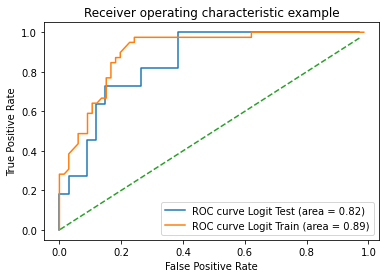

In [8]:
# Ploteamos el area bajo la curva in sample y out sample:
plt.plot(fprListLogisticTest, tprListLogisticTest,  label='ROC curve Logit Test (area = %0.2f)' % AUC2)
plt.plot(fprListLogisticTrain, tprListLogisticTrain,  label='ROC curve Logit Train (area = %0.2f)' % AUC1)
plt.plot(fprListLogisticTest, fprListLogisticTest, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

#### Grid Search

El grid search es una busqueda exhaustiva del modelo que mejor optimiza una o un conjunto de métricas de performance (por ejemplo AUC, R2, MSE) sujeto a valores de hyper-parámetros especificados en una grilla para uno o múltiples estimadores. 

Formalmente, siguiendo esta lógica, podríamos pensar en el Grid Search como un método de optimización en el cual escogemos los parámetros $\beta^* = \beta(\Omega)$, los hyper parametros $\alpha^* = \alpha(\Omega)$, y la estructura del modelo $\Omega$ que optimizan la métrica de performance en la data de testeo $\Delta_{test}$.

Modelo de predicción:

\begin{align}
y^*_{train} & = g(\theta^*,\alpha^*, \Omega | X_{train}) \\
\end{align}

La métrica de performance:

\begin{align}
\Delta & = \Delta(y_{test}, y^*_{test}) \\
\end{align}

El problema de optimización:

\begin{align}
\theta^*,\alpha^*, \Omega = arg max_{\{\theta^*,\alpha^*, \Omega\}} \{ \Delta (\theta^*,\alpha^*, \Omega, | X_{test}) \} \\
\end{align}



In [10]:
# Generamos una funcion que obtiene X, Y y el metodo ML que deseamos utililzar ademas de la semilla aleatoria que nos permite partir el dataset

def getOutOfSampleAUC(X, Y, clf, seed=0):

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

    clf = clf.fit(X_train[:,:2], Y_train) # Definir el problema
    predictionScoreTrain = clf.predict_proba(X_train)[:,-1]
    predictionScoreTest = clf.predict_proba(X_test)[:,-1]

    #Prediction in sample
    fprListTrain, tprListTrain,_ =  metrics.roc_curve(Y_train,predictionScoreTrain)
    AUC_train = metrics.auc(fprListTrain, tprListTrain)

    #Prediction out of sample
    fprListTest, tprListTest,_ =  metrics.roc_curve(Y_test,predictionScoreTest)
    AUC_test = metrics.auc(fprListTest, tprListTest)

    return AUC_train, AUC_test


# Cross validation:

def getCrossValidation(X,Y,clf):

    seedList = np.random.randint(1,1000,10)

    AUC_train_list = []
    AUC_test_list  = []
    for seed in seedList:
        AUC_train, AUC_test = getOutOfSampleAUC(X,Y,clf,seed)
        AUC_train_list.append(AUC_train)
        AUC_test_list.append(AUC_test)

    AUC_Levels   = pd.DataFrame(pd.DataFrame({0:AUC_train_list,1:AUC_test_list}).unstack()).reset_index()
    AUC_Levels['Estimator'] = clf.__class__.__name__

    return AUC_Levels

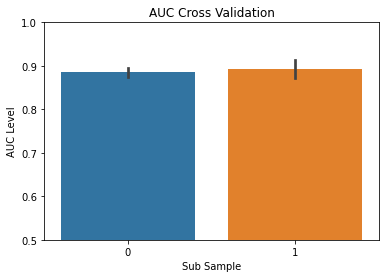

In [12]:
AUC_Levels = getCrossValidation(X,Y,clf)

sns.barplot(x = 'level_0', y=0, data = AUC_Levels)
plt.xlabel('Sub Sample')
plt.ylabel('AUC Level')
plt.ylim([.5,1])
plt.title('AUC Cross Validation')
plt.show()


# Applying Grid Search
modelList = [
LogisticRegression(random_state=0),
KNeighborsClassifier(5, weights='uniform'),
tree.DecisionTreeClassifier(max_depth=2),
RandomForestClassifier(max_depth=2, random_state=0)
]

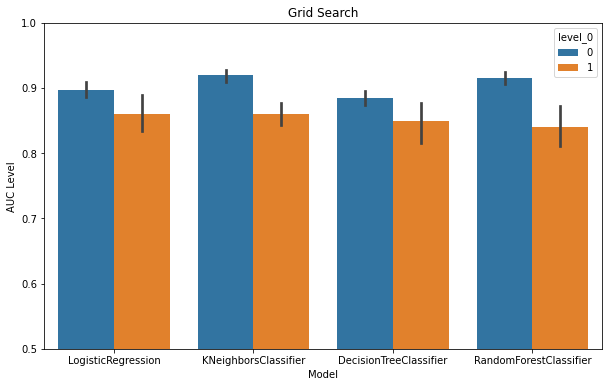

In [13]:
# Grid Search:

AUC_LevelsList= []
for clf in modelList: AUC_LevelsList.append(getCrossValidation(X,Y,clf))

AUC_Levels = pd.concat(AUC_LevelsList)


plt.figure(figsize=(10,6))
sns.barplot(x = 'Estimator', y=0, hue='level_0', data = AUC_Levels)
plt.xlabel('Model')
plt.ylabel('AUC Level')
plt.ylim([.5,1])
plt.title('Grid Search')
plt.show()